### Installing all libraries

In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


### Reading the Dataframes

In [3]:
df = pd.read_csv("./ClusteringDataSet/AGDummyTrain.csv")

In [4]:
df.head()

,Unnamed: 0,text,label
0,NaN,NaN,NaN
1,1.0,The Race is On: Second Private Team Sets Launc...,3.0
2,2.0,Ky. Company Wins Grant to Study Peptides (AP) ...,3.0
3,3.0,Prediction Unit Helps Forecast Wildfires (AP) ...,3.0
4,4.0,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3.0


### Basic Info

In [5]:
df["label"].value_counts()

label
3.0    1445
2.0     339
1.0      93
0.0      81
Name: count, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1958 non-null   float64
 1   text        1958 non-null   object 
 2   label       1958 non-null   float64
dtypes: float64(2), object(1)
memory usage: 178.2+ KB


In [7]:
#remove additonal and irrelevent columns
df = df[["text","label"]]

In [8]:
df.shape

(7600, 2)

In [9]:
df = df.dropna() #drop null values

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1958 entries, 1 to 7599
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    1958 non-null   object 
 1   label   1958 non-null   float64
dtypes: float64(1), object(1)
memory usage: 45.9+ KB


In [11]:
df.shape 

(1958, 2)

In [12]:
df.head()

,text,label
1,The Race is On: Second Private Team Sets Launc...,3.0
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3.0
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3.0
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3.0
5,Open Letter Against British Copyright Indoctri...,3.0


In [13]:
df["label"].value_counts()

label
3.0    1445
2.0     339
1.0      93
0.0      81
Name: count, dtype: int64

### Plot

In [14]:
label_counts = []
labels = []

for i in range(4):
    labels.append(i)
    label_counts.append(df["label"].value_counts()[i])

labels , label_counts

([0, 1, 2, 3], [81, 93, 339, 1445])

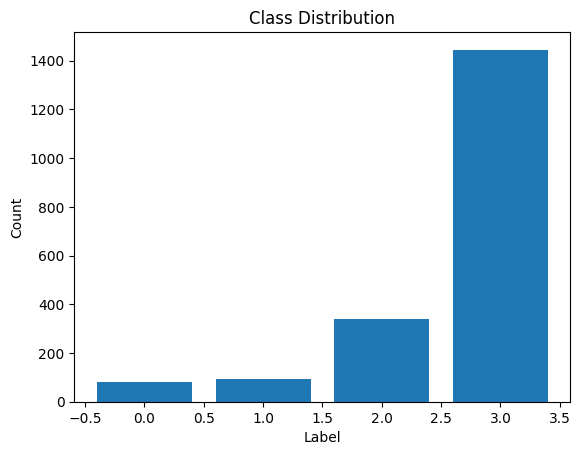

In [15]:
plt.bar(labels, label_counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

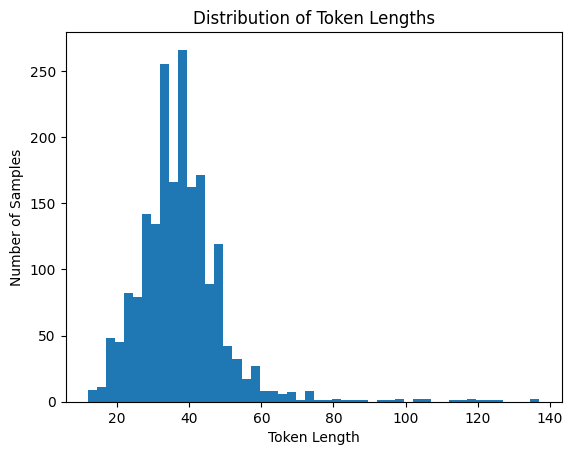

In [16]:
token_lengths = [len(text.split()) for text in df['text']]
plt.hist(token_lengths, bins=50)
plt.xlabel('Token Length')
plt.ylabel('Number of Samples')
plt.title('Distribution of Token Lengths')
plt.show()


- Class Dist
    - Data is highly imbalance we need to make sure that datapoints supposed to be equal
    - Merging of datapoints of 0,1,2 and make them as a single class may work. it'll helpfull in focus over class 3.
- Hist
    - Most text samples have token lengths between 30 and 50.
    - There are outliers at both ends—extremely short texts (approx. 12 tokens) and extremely long texts (approx. 137 tokens).
    - The distribution is somewhat right-skewed, with fewer long texts.
    - Setting a max sequence length around 50-60 tokens would likely capture most of the dataset without excessive truncation or padding.

In [17]:
df = df.replace(1, 0)
df= df.replace(2, 0)
df= df.replace(3, 1)

In [18]:
df["label"].value_counts()

label
1.0    1445
0.0     513
Name: count, dtype: int64

In [19]:
df.head()

,text,label
1,The Race is On: Second Private Team Sets Launc...,1.0
2,Ky. Company Wins Grant to Study Peptides (AP) ...,1.0
3,Prediction Unit Helps Forecast Wildfires (AP) ...,1.0
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,1.0
5,Open Letter Against British Copyright Indoctri...,1.0


### check cuda

In [20]:
import torch

print(torch.cuda.is_available())  # Should return True if CUDA is available


True


### BERT Testing

In [21]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize the sentence
input_ids = tokenizer.encode('Hello, this is a BERT tutorial!', add_special_tokens=True)

print('Input IDs:', input_ids)

Input IDs: [101, 7592, 1010, 2023, 2003, 1037, 14324, 14924, 4818, 999, 102]


C:\Users\amank\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Processing

In [22]:
# Define max length for padding/truncation
max_length = 55

In [23]:
# Tokenize the dataset
tokens = tokenizer(
    df['text'].tolist(),
    max_length=max_length,
    padding='max_length',  # Pad sequences to the same length
    truncation=True,       # Truncate sequences longer than max_length
    return_tensors='pt'    # Return PyTorch tensors
)

In [24]:
# Extract token IDs and attention masks
input_ids = tokens['input_ids']
attention_masks = tokens['attention_mask']

In [25]:
len(input_ids) , len(attention_masks)

(1958, 1958)

In [26]:
#Preparling labels

import torch

labels = torch.tensor(df['label'].values)

In [27]:
from torch.utils.data import DataLoader, TensorDataset

# Create a dataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a DataLoader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [28]:
from transformers import BertForSequenceClassification

# Load pre-trained BERT model for classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [29]:
num_classes = model.config.num_labels  # Assuming you're using BertForSequenceClassification
if torch.any(labels >= num_classes) or torch.any(labels < 0):
    print("Invalid label values detected.")


In [30]:
invalid_labels = labels[(labels >= num_classes) | (labels < 0)].cpu()
print("Invalid labels found:", invalid_labels)

Invalid labels found: tensor([], dtype=torch.float64)


In [31]:
print("Number of invalid labels:", len(invalid_labels))

Number of invalid labels: 0


In [32]:
print(torch.unique(labels))

tensor([0., 1.], dtype=torch.float64)


In [33]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

C:\Users\amank\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [34]:
from torch.nn import CrossEntropyLoss

loss_fn = CrossEntropyLoss()

# Initialize total_loss
total_loss = 0.0

for batch in dataloader:
    input_ids, attention_masks, labels = [x.to(device) for x in batch]
    
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(input_ids, attention_mask=attention_masks)
    logits = outputs.logits
    
    # Ensure logits are FloatTensor and labels are LongTensor
    logits = logits.float()
    labels = labels.long()
    
    # Compute the loss
    loss = loss_fn(logits, labels)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Accumulate loss
    total_loss += loss.item()

print("Total Loss:", total_loss)


C:\Users\amank\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Total Loss: 37.01035329699516


In [35]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Testing

In [36]:
testdf = pd.read_parquet("./ClusteringDataSet/test-00000-of-00001.parquet")

In [37]:
testdf

,text,label
0,Fears for T N pension after talks Unions repre...,2
1,The Race is On: Second Private Team Sets Launc...,3
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3
...,...,...
7595,Around the world Ukrainian presidential candid...,0
7596,Void is filled with Clement With the supply of...,1
7597,Martinez leaves bitter Like Roger Clemens did ...,1
7598,5 of arthritis patients in Singapore take Bext...,2


In [38]:
# Tokenize and pad the test dataset
inputs = tokenizer(testdf['text'].tolist(), padding=True, truncation=True, max_length=55, return_tensors='pt')

# Extract input tensors
test_input_ids = inputs['input_ids']
test_attention_masks = inputs['attention_mask']

In [39]:
from torch.utils.data import DataLoader, TensorDataset

# Assuming `test_labels` are not needed for inference, otherwise include them
test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [40]:
testdf = testdf.replace(1, 0)
testdf = testdf.replace(2, 0)
testdf = testdf.replace(3, 1)

In [67]:
from sklearn.metrics import accuracy_score, classification_report

# Initialize lists to store predictions
predictions = []
threshold = 0.90 # to imporve precision for class 1 
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_masks = [x.to(device) for x in batch]
        
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        
        # Get predicted class
        preds = torch.softmax(logits, dim=1)
        # Apply the threshold
        preds = (preds[:, 1] > threshold).long()
        predictions.extend(preds.cpu().numpy())

# Convert predictions to a DataFrame or other suitable format
testdf['predictions'] = predictions




In [68]:
testdf.head()

,text,label,predictions
0,Fears for T N pension after talks Unions repre...,0,0
1,The Race is On: Second Private Team Sets Launc...,1,1
2,Ky. Company Wins Grant to Study Peptides (AP) ...,1,1
3,Prediction Unit Helps Forecast Wildfires (AP) ...,1,1
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,1,0


In [69]:
true_labels = testdf['label'].tolist()
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9268


In [70]:
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      5700
           1       0.93      0.76      0.84      1900

    accuracy                           0.93      7600
   macro avg       0.93      0.87      0.90      7600
weighted avg       0.93      0.93      0.92      7600



## 1: Report

The classification report provides a detailed evaluation of a classification model's performance. Here's a breakdown of each component:

### **1. Precision, Recall, F1-Score, and Support**

For each class:

- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives. It tells you how many of the predicted positive cases were actually positive.

  \[
  \text{Precision} = \frac{TP}{TP + FP}
  \]

  Where TP is True Positives and FP is False Positives.

- **Recall**: The ratio of correctly predicted positive observations to all observations in the actual class. It tells you how many of the actual positive cases were correctly predicted.

  \[
  \text{Recall} = \frac{TP}{TP + FN}
  \]

  Where FN is False Negatives.

- **F1-Score**: The harmonic mean of Precision and Recall. It provides a balance between Precision and Recall.

  \[
  \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
  \]

- **Support**: The number of actual occurrences of the class in the dataset.

### **Overall Metrics**

- **Accuracy**: The ratio of correctly predicted observations to the total observations. It is a general measure of how well the model performs.

  \[
  \text{Accuracy} = \frac{\text{TP + TN}}{\text{Total}}
  \]

  Where TN is True Negatives.

- **Macro Average**: The average performance across all classes, calculated independently for each class and then averaged. This metric treats all classes equally, regardless of their support.

- **Weighted Average**: The average performance across all classes, weighted by the support of each class. It accounts for the imbalances in class distributions by giving more weight to classes with more instances.

The classification report you provided gives a detailed performance evaluation of your model. Here’s a breakdown of the metrics:

- **Metrics Breakdown**
**Precision**:

Class 0: 0.93
Class 1: 0.93
Overall: Precision is the ratio of correctly predicted positive observations to the total predicted positives. High precision indicates that the model is making fewer false positive predictions.

**Recall**:

Class 0: 0.98
Class 1: 0.76
Overall: Recall is the ratio of correctly predicted positive observations to all observations in the actual class. High recall means the model is capturing most of the positive instances.

**F1-Score**:

Class 0: 0.95
Class 1: 0.84
Overall: The F1-score is the weighted average of precision and recall. It is useful when you need a balance between precision and recall and is particularly useful when dealing with imbalanced datasets.

**Support**:

Class 0: 5700 (number of actual instances of class 0 in the test set)
Class 1: 1900 (number of actual instances of class 1 in the test set)

**Accuracy**:

Overall: 0.93
Accuracy is the ratio of correctly predicted observations to the total observations. In this case, 93% of the test set was correctly classified.

**Macro Average**:

Precision: 0.93
Recall: 0.87
F1-Score: 0.90
Macro average calculates metrics for each label and finds their unweighted mean. This does not take label imbalance into account.

**Weighted Average**:

Precision: 0.93
Recall: 0.93
F1-Score: 0.92
Weighted average calculates metrics for each label and finds their average, weighted by support (the number of true instances for each label). This accounts for label imbalance.

**Insights**
Class 0: Your model performs exceptionally well, with high precision, recall, and F1-score. This indicates that it can effectively classify instances of class 0.
Class 1: The precision is high, but recall is somewhat lower. This means your model is relatively good at predicting class 1 when it predicts it, but it misses some instances of class 1.


## 2: Challanges and Solutions

Here’s a summary of the challenges you faced during your classification project with BERT and the solutions to each:

### **1. Handling Class Imbalance**

**Challenge**: Your dataset had a significant class imbalance, with one class (3.0) being much more prevalent than the others.

**Solution**: 
- **Combining Classes**: You combined classes 0.0, 1.0, and 2.0 into a single class to focus on correctly classifying the majority class (3.0). This helps simplify the problem and makes the model's task clearer.
- **Accuracy before combination** : Accuracy: 0.6372
- **Accuracy after combination** : Accuracy: 0.92

### **2. Token Length Variation**

**Challenge**: Your textual data had varying token lengths, which can cause issues with models expecting fixed input sizes.

**Solution**:
- **Padding and Truncation**: You decided to truncate longer texts and pad shorter texts to a fixed length of 55 tokens. This ensures that all input sequences have the same length, which is necessary for BERT.

### **3. Model Training Issues**

**Challenges**:
- **Mismatch in Batch Size**: During training, you encountered a batch size mismatch error, indicating that the input and target batch sizes were inconsistent.
- **Tensor Type Errors**: Errors related to tensor types (`Double` instead of `Float`) and label type mismatches.
- **CUDA Errors**: Encountered CUDA errors related to device-side assertions and incorrect tensor types.

**Solutions**:
- **Batch Size Fix**: Ensure that the `input_ids`, `attention_masks`, and `labels` all have consistent dimensions when passed to the model.
- **Tensor Type Correction**: Convert tensors to the correct types using `.float()` for logits and `.long()` for labels.
- **CUDA Errors**: Use `CUDA_LAUNCH_BLOCKING=1` for debugging, and ensure tensors are on the correct device.

### **4. Evaluation and Metrics**

**Challenge**: Understanding and interpreting model performance metrics to evaluate its effectiveness.

**Solution**:
- **Classification Report**: Use metrics like precision, recall, and F1-score to evaluate model performance. These metrics provide insights into how well the model performs across different classes, especially when dealing with imbalanced datasets.
- **Precision Control**: In first iteration, it's accuracy was 94% but as our major interest is class 1 the precision for class 1 was only 74% which needs to be handel carefully. Hence, we introduce the concept of threshold, the best threshold we figure out it 0.9 for which we compromise with accuracy by 2% but precision for class 1 improves significantly to 92%. 

### **5. Model Inference and Testing**

**Challenge**: Testing the model on a pandas DataFrame containing the test data.

**Solution**:
- **Data Preparation**: Tokenize and pad the test data similarly to the training data. Create a `DataLoader` for efficient batch processing.
- **Inference**: Perform inference using the trained model and convert predictions to a suitable format for evaluation.

### **Summary of Solutions**

1. **Class Imbalance**: Combine minor classes to simplify the problem and focus on major class.
2. **Token Length**: Pad and truncate sequences to a fixed length.
3. **Training Issues**: Ensure consistent tensor dimensions and types; handle CUDA errors by debugging.
4. **Evaluation**: Use classification metrics to understand model performance.
5. **Testing**: Preprocess test data similarly to training data, perform inference, and evaluate the results.

